In [ ]:
### getting PCA loadings and classifier feature gains for Zhang Melzer et al. 2023
### Created by Madeline E Melzer on 20240103
### Last edited by Madeline E Melzer on 20240103

In [1]:
import os
import xgboost
import sklearn
import numpy as np
import pandas as pd
import anndata
import scipy
import xgbfir
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.io import mmread
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from joblib import dump, load
from matplotlib import pyplot


from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

np.random.seed(23)

/Users/mem3579/anaconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mem3579/anaconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mem3579/anaconda3/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepreca

In [2]:
def load_and_preprocess_data(counts_dir, labels_dir):
    os.chdir(counts_dir)

    # Read the .mtx file
    matrix = scipy.io.mmread("matrix.mtx")
    matrix = matrix.transpose()
    matrix_array = matrix.toarray()

    # Read the features and barcodes files
    genes = pd.read_csv("features.tsv.gz", header=None, sep="\t")
    genes_list = genes.index.tolist()
    first_column = genes.columns[0]
    genes = genes.set_index(first_column) #this is to ensure the anndata object is created correctly and that there are no extra columns in the features or barcodes dfs
    barcodes = pd.read_csv("barcodes.tsv.gz", header=None, sep="\t")
    first_column = barcodes.columns[0]
    barcodes = barcodes.set_index(first_column)

    # Create the AnnData object
    data = anndata.AnnData(X=matrix_array, var=genes_list, obs=barcodes)

    # getting singlet and multiplet labels
    os.chdir(labels_dir)
    labels_df = pd.read_csv(f'labels_2.csv') #for "variable doublet rates", indicate _{dataset} here

    ############## Preprocessing data

    # combining features matrix and labels
    data.obs.index = data.obs.index.rename('barcode')
    merged = data.obs.merge(labels_df, on='barcode', how='inner')
    #print(merged.head()) #checking what the merged looks like

    # Extract the features matrix and labels
    features = data.X
    labels = merged['label'].values
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique_labels, counts))) #checking the number of singlets and multiplets

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = 1 - labels_encoded #switching the labels so that 1s are multiplets and 0s are singlets, so correclty identified 1s are considered true positives
    counts = np.bincount(labels_encoded)
    #print(counts) #checking that the number of singlets and multiplets is the same as above

    barcodes_1 = data.obs.index.to_numpy() #getting the barcodes for the features matrix to identify the cells that are being classified

    return features, labels_encoded, barcodes_1, matrix_array, genes

In [ ]:
# Dimensionality reduction and data visualization

from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

# Perform PCA on your features
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data = pca_result, columns = ['PC' + str(i) for i in range(1, 51)])

# Add the labels to the DataFrame
pca_df['Label'] = labels_encoded

# Plot the PCA results colored by label
plt.figure(figsize=(8,8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Label'])
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(handles=scatter.legend_elements()[0], labels=set(pca_df['Label']))
plt.show()

In [55]:
def getLoadings(features, genes_list, labels_encoded):

    genes_list = genes_list.index.tolist()
    
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(features)
    
    pca_df = pd.DataFrame(data = pca_result, columns = ['PC' + str(i) for i in range(1, 51)])
    pca_df['Label'] = labels_encoded

    # Get the loadings from the PCA
    loadings = pd.DataFrame(pca.components_.T, columns = ['PC' + str(i) for i in range(1, 51)], index = genes_list)

    return pca, pca_result, loadings


In [28]:
def getImportances(classifier, dataset, genes_list):
    #getting importances
    booster = classifier.get_booster()
    booster.feature_names = genes_list.index.tolist()
    gain = booster.get_score(importance_type='gain')
    cover = booster.get_score(importance_type='cover')
    weight = booster.get_score(importance_type='weight')
    total_gain = booster.get_score(importance_type='total_gain')
    total_cover = booster.get_score(importance_type='total_cover')
    importance_df = pd.DataFrame({'gain': gain, 'cover': cover, 'weight': weight, 
                                  'total_gain': total_gain, 'total_cover': total_cover})
    #importance_df = importance_df.transpose()
    #importance_df['gene_name'] = genes_list
    total_gain_all_genes = importance_df['total_gain'].sum()
    importance_df['average_total_gain'] = importance_df['total_gain'] / total_gain_all_genes
    importance_df['dataset'] = dataset
    #importance_df.to_csv(importancesDir + f'{dataset}_scores_selfmodel.csv')
    print(f"{dataset}")
    print(importance_df.head(10))


    return importance_df

In [40]:
### examining the loadings and feature importances for the sample 1 classifier

classifiers_dir = "/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/classifiers/"
count = 1

# loading and formatting sample 2 data
dataset = "s1s2"
counts_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/s1s2", dataset, "10X_doublets_2/")
labels_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/s1s2", dataset)
features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)

summary_df = pd.DataFrame(columns = ["dataset", "condition", "auroc", "auprc", "accuracy", "best_params"])

sample1Classifier = load(classifiers_dir + f'sample1_{count}_fit.joblib')
# predict sample 2 outcome using sample 1's classifier
preds_proba = sample1Classifier.predict_proba(features)[:,1]  # Get probabilities of the positive class (multiplets- 1)
auroc = roc_auc_score(labels_encoded, preds_proba) # Calculate AUROC
print(f"AUROC: {auroc}")
auprc = average_precision_score(labels_encoded, preds_proba) # Calculate AUPRC
print(f"AUPRC: {auprc}")
y_preds = sample1Classifier.predict(features) # Predict labels on the test set
accuracy = accuracy_score(labels_encoded, y_preds) # Calculate accuracy
print(f"Accuracy: {accuracy}")  
summary_dict = {"dataset": dataset, "condition": "sample1", "auroc": auroc, "auprc": auprc, "accuracy": accuracy}  


{'doublet': 948, 'singlet': 8532}
AUROC: 0.9595193622025594
AUPRC: 0.8251609064446531
Accuracy: 0.9042194092827004


In [56]:
# getting loadings
pca, pca_result, loadings = getLoadings(features, genes, labels_encoded)

# getting importances
importances = getImportances(sample1Classifier, dataset, genes)

s1s2
                gain       cover  weight  total_gain  total_cover  \
ACTA2      53.943169  396.874268     1.0   53.943169   396.874268   
PMEL        9.596087  194.174942     2.0   19.192173   388.349884   
TFPI2       0.678239    7.001111     1.0    0.678239     7.001111   
IFIT2       1.525985    9.910835     1.0    1.525985     9.910835   
IGFBP2     47.573975  405.641022     1.0   47.573975   405.641022   
SERPINE1    7.546163   16.824503     1.0    7.546163    16.824503   
CITED1     21.184155   29.512098     1.0   21.184155    29.512098   
VGF         4.933934   13.214450     1.0    4.933934    13.214450   
FN1        86.745140  178.454208     1.0   86.745140   178.454208   
TDO2      196.131226   43.114262     1.0  196.131226    43.114262   

          average_total_gain dataset  
ACTA2               0.001101    s1s2  
PMEL                0.000392    s1s2  
TFPI2               0.000014    s1s2  
IFIT2               0.000031    s1s2  
IGFBP2              0.000971    s1s2  
S

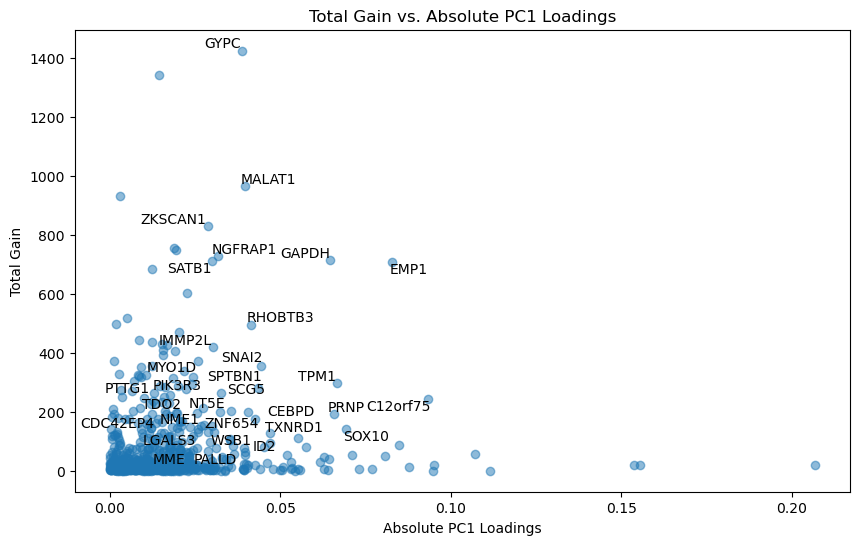

In [43]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

loadings['PC1_abs'] = loadings['PC1'].abs()
merged_df = loadings.reset_index().merge(importances.reset_index(), on='gene_name', how='inner')

# Set thresholds
total_gain_threshold = merged_df['total_gain'].quantile(0.80)  # top 5% total_gain
pc1_abs_threshold = merged_df['PC1_abs'].quantile(0.80)  # top 5% absolute PC1 loadings

# Filter points above thresholds
filtered_df = merged_df[(merged_df['total_gain'] > total_gain_threshold) & (merged_df['PC1_abs'] > pc1_abs_threshold)]

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['PC1_abs'], merged_df['total_gain'], alpha=0.5)

texts = [plt.text(row['PC1_abs'], row['total_gain'], idx, ha='center', va='center') 
         for idx, row in filtered_df.iterrows()]
adjust_text(texts)

plt.title('Total Gain vs. Absolute PC1 Loadings')
plt.xlabel('Absolute PC1 Loadings')
plt.ylabel('Total Gain')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the pca_result array to a DataFrame and add column names for principal components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Assuming 'labels_encoded' is a 1D array or list with the same length as pca_result's rows
pca_df['Label'] = labels_encoded

# Now, you can plot the principal components against each other
# Adjust the range as needed, here we plot the first few PCs
for i in range(1, min(len(pca_df.columns)-1, 50)):  # Subtract 1 to account for the 'Label' column
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=f'PC22', y=f'PC37', hue='Label', data=pca_df, palette='viridis')
    plt.title(f'Scatter Plot of PC{i} vs PC{i+1}')
    plt.show()
